# 1. Problema de Negócio

Muito tem sido dito durante os últimos anos sobre como a medicina de precisão e, mais concretamente, como o teste genético, vai provocar disrupção no tratamento de doenças como o câncer.

Mas isso ainda está acontecendo apenas parcialmente devido à enorme quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar  a medicina personalizada ao seu potencial máximo. Uma vez sequenciado, um tumor cancerígeno pode ter milhares de mutações genéticas. O desafio é distinguir as mutações que contribuem para o  crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita  manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem  que revisar manualmente e classificar cada mutação genética com base em  evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) está  disponibilizando uma base de conhecimento anotada por especialistas, onde pesquisadores e oncologistas de nível mundial anotaram manualmente milhares de mutações.

Dataset: https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview

# 2. Imports

In [72]:
import nltk
import spacy
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from warnings import simplefilter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy import sparse
from os.path import isfile
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [68]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

nltk      : 3.6.1
xgboost   : 1.4.2
pandas    : 1.2.4
matplotlib: 3.3.4
re        : 2.2.1
seaborn   : 0.11.1
scipy     : 1.7.0
spacy     : 3.1.0
numpy     : 1.19.5



## 2.1 Ambiente

In [3]:
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_theme()

In [4]:
seed_ = 194
np.random.seed(seed_)

# 3. Carregamento dos Dados

In [5]:
# Carregando datatable de treino com as variantes
variant = pd.read_csv('data/training_variants')

In [6]:
# Carregando datatable de treino com os textos de caso
text_data = pd.read_csv('data/training_text', sep = '\|\|', engine = 'python', names = ['ID', 'Text'], skiprows = 1)

In [7]:
variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
text_data.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
# Unificando os dois datatable pela coluna 'ID' 
train_data = pd.merge(variant, text_data, on = 'ID', how = 'left')

In [10]:
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# 4. Analise Exploratoria

In [11]:
# Possuimos 3321 observações para treino
train_data.shape

(3321, 5)

In [12]:
# Verificando se os tipos das colunas estão corretos
train_data.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

É analisado que possuimos valores missing para a coluna 'Text' para uma melhor generalização, e não descartar os dados iremos fazer que os dados missing sejam preenchidos pelo valor de 'Gene' + 'Variation'. 

In [13]:
# Verificando valores missing
print(train_data.isna().sum())

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64


É interessante notar que possuimos 264 'Gene' diferentes e 2996 'Variation', também possuimos 1920 'Text'. Considerando que temos 3321 observações, o numero de 'Variation' unicas é muito alto, podendo prejudicar o modelo.

In [14]:
# Verificando valores unicos
print(train_data.nunique())

ID           3321
Gene          264
Variation    2996
Class           9
Text         1920
dtype: int64


In [15]:
# Verificando valores duplicados
print(sum(train_data.duplicated()))

0


## 4.1 Analise Univariavel

Algumas classes como 3, 9 e 8 possuimos muitos poucos dados, o que pode gerar um problema no aprendizado do nosso modelo. Induzindo a determinados víes. Um balanceamento pode auxiliar.

<AxesSubplot:>

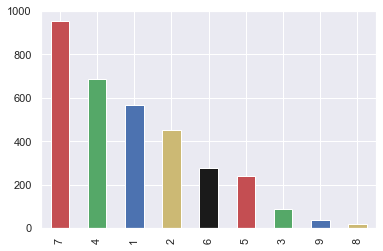

In [16]:
# Criando vetor de cores
colors = ['r', 'g', 'b', 'y', 'k']

train_data['Class'].value_counts().plot(kind = 'bar', color = colors)

In [17]:
# Funções para analise univariavel

def distribuicao_column(data, column, distribuicao_nao_cumulativa = True, distribuicao_cumulativa = True):
    # Calculando distribuição da coluna
    valores = data[column].value_counts()
    distribuicao_valores = valores / sum(valores.values)
    
    if distribuicao_nao_cumulativa:
        plt.plot(distribuicao_valores)
        plt.xlabel(column)
        plt.ylabel('Taxa de Observações')
        plt.show()
        
    if distribuicao_cumulativa:
        plt.plot(np.cumsum(distribuicao_valores))
        plt.xlabel(column)
        plt.ylabel('Taxa de Observações')
        plt.show()
        
def relevancia_classe(data, column, column_target, top = 10):
    top_significancia = round( ( sum(data.groupby(by = column).count().sort_values(by = 'ID',\
                                                ascending = False).head(top)[column_target]) / data.shape[0] ) * 100, 2)

    representacao_column = round( (top / data.nunique()[column]) * 100, 2)

    print(representacao_column, '% da coluna', column,'representa', top_significancia, '% da coluna', column_target)
    
def top_frequencias(data, column, column_target, ID, top = 10, colors = ['r', 'g', 'b', 'y', 'k']):
    data.groupby(by = column).count().sort_values(by = ID, ascending = False).head(top).plot(\
                                        kind = 'bar', ylabel = 'Frequencia', xlabel = column, y = column_target,\
                                        color = colors)

Para melhor entendimento dos dados é interessante analisar o acumulo do numero de genes ao longo da sua distribuição, de forma não cumulativa e cumulativa. Já no segundo grafico mais uma vez é perceptivel que o grafico tende a crescer mais rapidamente no inicio, tendendo a uma forma exponencial.

No primeiro grafico é perceptivel que muitos 'Genes' concentram uma maior taxa de ocorrencia, o que tende a cair rapidamente em relação aos outros.

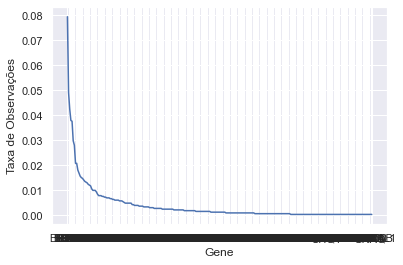

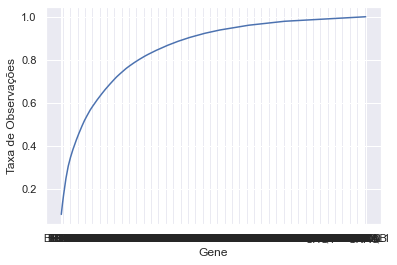

In [18]:
distribuicao_column(train_data, 'Gene')

Analisando abaixo é perceptivel que os 10 Genes com maior frequência representam 36% das classes, assim essas possuem a maior relevancia para o nosso modelo. Porém isso significa que apenas 3.8% dos nossos genes representam 36% das classes.

In [19]:
relevancia_classe(train_data, 'Gene', 'Class')

3.79 % da coluna Gene representa 36.4 % da coluna Class


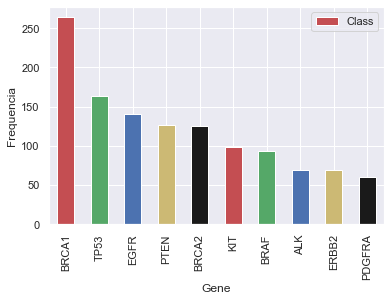

In [20]:
top_frequencias(train_data, 'Gene', 'Class', 'ID', colors = colors)

Apos analisar os genes é necessário analisar a 'Variation' pois essa já foi identificada que possui mais valores unicos.

Apenas as 10 variations de maior relevancia, ou seja 0.33% dos tipos de 'Variation' representam um total de 8.85% das classes alvo.

In [21]:
relevancia_classe(train_data, 'Variation', 'Class')

0.33 % da coluna Variation representa 8.85 % da coluna Class


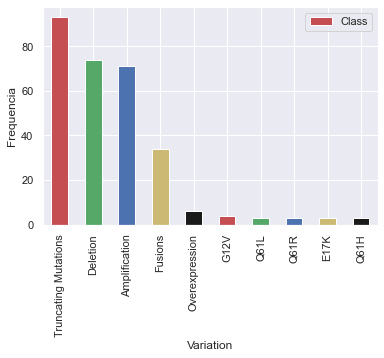

In [22]:
top_frequencias(train_data, 'Variation', 'Class', 'ID', colors = colors)

É perceptivel que possuem algumas poucas 'Variations' que possuem uma relevancia muito maior que as outras, porém o restante possui uma relevância similar. Observando a variancia acumulada temos o mesmo comportamento, um pulo no inicio e após um crescimento que se torna constante.

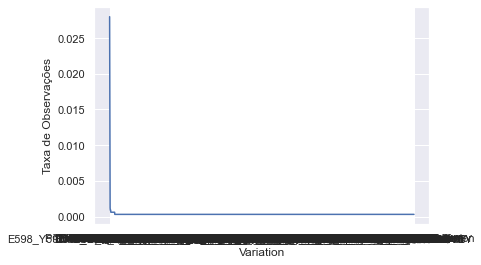

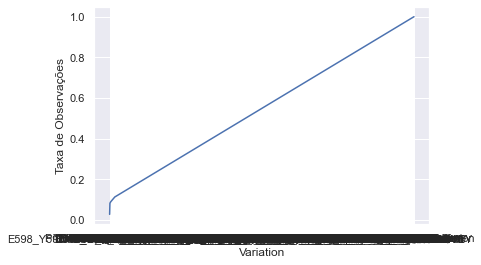

In [23]:
distribuicao_column(train_data, 'Variation')

## 4.2 Tabela de Contigencia

In [18]:
qualitativas = ['Gene', 'Variation']

In [19]:
def crosstab_column(data, col, target, percentage = True):
    res = pd.crosstab(data[col], data[target], margins = True)
    
    if percentage:
        res = pd.crosstab(data[col], data[target], margins = True, normalize = 'index').round(4) * 100
    
    return res

Analisando de forma generalizada é perceptivel qque determinados 'Gene' estão amplamente concentrados em uma categoria, o mesmo serve para 'Variation' que possui uma especificidade ainda maior.

Por exemplo, o 'Gene' ABL1 estã 92% na classe 2 e o restante, 7.69%, na classe 7. Já para 'Variation' o valor '1_2009trunc' esta 100% na classe 1.

In [20]:
for col in qualitativas:
    print(crosstab_column(train_data, col, 'Class'), end = '\n\n\n')

Class        1      2      3      4      5       6      7     8      9
Gene                                                                  
ABL1       0.0  92.31   0.00   0.00   0.00    0.00   7.69  0.00   0.00
ACVR1      0.0  33.33   0.00   0.00   0.00    0.00  66.67  0.00   0.00
AGO2      80.0  20.00   0.00   0.00   0.00    0.00   0.00  0.00   0.00
AKT1       0.0  10.71  10.71   0.00  10.71    0.00  60.71  7.14   0.00
AKT2       0.0   9.09   0.00   0.00   0.00    0.00  72.73  0.00  18.18
...        ...    ...    ...    ...    ...     ...    ...   ...    ...
WHSC1L1    0.0   0.00   0.00   0.00   0.00  100.00   0.00  0.00   0.00
XPO1       0.0  50.00   0.00   0.00   0.00   50.00   0.00  0.00   0.00
XRCC2    100.0   0.00   0.00   0.00   0.00    0.00   0.00  0.00   0.00
YAP1       0.0  75.00   0.00   0.00   0.00    0.00  25.00  0.00   0.00
All       17.1  13.61   2.68  20.66   7.29    8.28  28.70  0.57   1.11

[265 rows x 9 columns]


Class                    1       2     3       4   

## QUI-QUADRADO

In [21]:
def qui2(data, col, target, alpha = 0.05):
    for c in col:
        cross = pd.crosstab(data[c], data[target])
        chi2, p, dof, exp = stats.chi2_contingency(cross)
        print("Qui-quadrado entre a variavel", target, "e a variavel categorica", c, ": {:0.4}".format(chi2))
        print("Apresentando um p-value de: {:0.4}".format(p))
        
        if p < alpha:
            print('A variavel', c,'possui relação direta com a variavel',target, end = '\n\n')
        else:
            print('A variavel', c,'não possui relação direta com a variavel',target, end = '\n\n')

Analisando o teste do qui-quadrado, as nossas variaveis apontam uma alta taxa de confiança entre a relação de ambas as variaveis qualitativas com a variavem target. 

In [22]:
qui2(train_data, qualitativas, 'Class')

Qui-quadrado entre a variavel Class e a variavel categorica Gene : 1.004e+04
Apresentando um p-value de: 0.0
A variavel Gene possui relação direta com a variavel Class

Qui-quadrado entre a variavel Class e a variavel categorica Variation : 2.559e+04
Apresentando um p-value de: 1.856e-13
A variavel Variation possui relação direta com a variavel Class



Visto que não possuimos dados quantitativos, a analise exploratoria finaliza por aqui. Concluindo que possuimos muitos valores unicos para ambas as features qualitativas. Possuimos uma grande parcela das classes atribuidas a poucos 'Genes' e 'Variations'.

Ambas as variaveis quantitativas possuem associação com a variavel target. O nivel de confiança é alto.

# 5. Pre Processamento

Possuimos valores NA para a coluna 'Text', para um melhor tratamento iremos subsituir o seu valor por: 'Gene' + 'Variaton'.

In [23]:
# Verificando os valores NA
train_data[train_data.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [24]:
train_data.loc[train_data['Text'].isnull(), 'Text'] = train_data['Gene'] + train_data['Variation']

In [25]:
def limpar_texto(text):
    # Convertendo para str
    text = str(text)
    
    # Remover caracteres non-ascii
    text = ''.join(caracter for caracter in text if ord(caracter) < 128)
    
    # Convertendo para lower case
    text = text.lower()
    
    # Removendo pontuação por expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    text = regex.sub(' ', str(text))
    
    # Carregando stopwords em Inglês
    english_stops = set(stopwords.words('english'))
    
    # Removendo stopwords em Inglês
    # Mantendo somente palavras que não são consideradas stopwords
    text = ' '.join(palavra for palavra in text.split() if palavra not in english_stops)
    
    # Criando a estrutura baseada em uma wordnet para lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()    
    # Aplicando Lemmatization
    text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())
    
    return text

In [26]:
def carap_data(path, data = [], column = 'x'):
    if isfile(path):
        print('Carregando conjunto de dados...')
        data = pd.read_csv(path, sep = ',')
    else:
        print('Tratanto texto...')
        data[column] = data[column].map(limpar_texto)
        print('Salvando dados...')
        data.to_csv(path, sep = ',')
    
    return data

Iremos executar uma série de operações para realizar a limpeza do texto e generalizar para os algoritmos:

- Garantir que todo o texto é do tipo str
- Remover caracteres não ascii
- Converter todo o texto para minusculo
- Remover pontuações e simbolos especiais
- Remover stopwords (Palavras que não trazem sentido para o texto)
- Lemmatização do texto baseado em uma wordnet

Lemmatization:
- Forma flexionada: organizando
- Lema: organiza

- Forma flexionada: organizado
- Lema: organiza

In [27]:
%%time
train_data_processado = carap_data('data/treino_processado.csv', train_data, 'Text')

Carregando conjunto de dados...
Wall time: 1.16 s


Segue comparação abaixo entre o texto da primeira linha antes de ser processado e após ser processado.

In [28]:
train_data['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

In [29]:
train_data_processado['Text'][0]

'cyclin dependent kinase cdks regulate variety fundamental cellular process cdk10 stand one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increase ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cell precise mechanism cdk10 modulates ets2 activity generally function cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutation cause star syndrome human developmental anomaly whose feature include toe syndactyly telecanthus anogenital renal malformation show star syndrome associated cyclin mutant unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cell cdk10 cyclin phosphorylates ets2 vitro cell positively control ets2 degradation proteasome ets2 protein level increased cell derived

In [30]:
# Contar palavras unicas
palavras_unicas = set()

train_data_processado['Text'].str.lower().str.split().apply(palavras_unicas.update)

print(len(palavras_unicas))

160553


## 5.1 TFIDF

Iremos calcular o TFIDF das palavras para entendermos a frequencia de ocorrencia por frase x documento. Porem iremos solicitar um df minimo para a palavra ser considerada, assim não iremos contar palavras com poucas ocorrencias, também iremos considerar que pode ser considerado: unigrama, bigrama e trigrama para uma melhor contextualização. Por ultimo iremos limitar a somente 1000 features em nosso TFIDF, assim buscando as palavras com maior impacto.

In [31]:
def gerar_TFIDF(path, data = [], max_features = 1000, ngram_range = (1, 1), min_df = 3): 
    if isfile(path):
        print('Carregando matriz TFIDF...')
        tfidf = np.load(path, allow_pickle = False)
    else:
        print('Gerando matriz TFIDF...')
        TFIDF = TfidfVectorizer(min_df = min_df, ngram_range = ngram_range, max_features = max_features)
        tfidf = TFIDF.fit_transform(data).toarray()
        np.save(path, tfidf, allow_pickle = False)
    
    print('Matriz TFIDF carregada')
    return tfidf

In [32]:
tfidf_train = gerar_TFIDF('data/tfidf_treino.npy', train_data_processado['Text'].values, 100000, (1, 3), 3)

Carregando matriz TFIDF...
Matriz TFIDF carregada


In [33]:
tfidf_train_dt = pd.DataFrame(tfidf_train, index = train_data_processado.index)

In [34]:
tfidf_train_dt.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.011535,0.0,0.0,0.0


## 5.2 Truncated SVD

Iremos utilizar o algoritmo de TruncatedSVD para reduzir os nossos dados a componentes, a sua vantagem em relação ao PCA é que o TruncatedSVD trabalha melhor com dados esparsos. A sua diferença é que não é realizado uma centralização dos dados. Assim irá ter melhores resultados com a nossa matriz de TFIDF.

In [35]:
def gerar_componentes_TruncatedSVD(path, n_components, data, n_iter = 50, seed = 120): 
    if isfile(path):
        print('Carregando componentes...')
        svd_componentes = np.load(path, allow_pickle = False)
    else:
        print('Gerando componentes...')
        svd = TruncatedSVD(n_components = n_components, n_iter = n_iter, random_state = seed)
        svd_componentes = svd.fit_transform(data)
        np.save(path, matriz_esparsa, allow_pickle = False)
    
    print('Componentes carregados')
    return svd_componentes

In [36]:
n_components = 1000
truncated_train = gerar_componentes_TruncatedSVD('data/matriz_esparsa_treino.npy', n_components,\
                                                 tfidf_train_dt, 50, seed_)

Carregando componentes...
Componentes carregados


In [37]:
truncated_train_dt = pd.DataFrame(truncated_train)

In [38]:
truncated_train_dt.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.209456,-0.082272,-0.019928,-0.072945,0.035063,0.015121,-0.017422,-0.006298,-0.007785,-0.018207,...,-0.000667,-0.013015,-0.007143,-0.004988,0.002724,0.010163,-0.007411,-0.020190,0.001096,0.009950
1,0.230858,-0.117900,-0.055719,0.066605,-0.050562,0.010161,-0.069204,0.020518,-0.002667,0.000851,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
2,0.230858,-0.117900,-0.055719,0.066605,-0.050562,0.010161,-0.069204,0.020518,-0.002667,0.000851,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
3,0.201979,-0.079566,-0.032508,0.007221,0.001920,0.006085,0.026844,0.011929,-0.014232,0.004337,...,-0.000602,0.000908,0.003219,0.003609,-0.002592,-0.001493,-0.004328,-0.000660,-0.000304,0.003618
4,0.215967,-0.065170,-0.015736,0.002577,-0.034887,0.008384,-0.038474,0.023668,-0.005299,-0.008350,...,-0.002130,0.000202,0.000001,0.000555,-0.000001,-0.001294,-0.000886,-0.002356,-0.000172,-0.001923


In [35]:
# Calcular taxa de variancia por componente
# Executar só se o grafico da variancia não estiver exibindo no output

svd = TruncatedSVD(n_components = 1000, n_iter = 50, random_state = seed_)
svd_componentes = svd.fit_transform(tfidf_train_dt)

variancia = svd.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancia * 100)

NameError: name 'svd' is not defined

Para o nosso caso 1000 componentes será o suficiente para o nosso modelo cobrir os dados, então iremos de 100.000 features para 1000 componentes, assim reduzindo a nossa dimensionalidade.

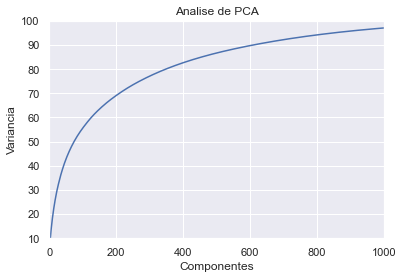

In [94]:
plt.ylabel('Variancia')
plt.xlabel('Componentes')
plt.title('Analise de PCA')
plt.ylim(10, 100)
plt.xlim(0, n_components)
plt.plot(variancia_acumulada)

In [39]:
# Renomeando colunas
truncated_train_dt.columns = [('Componente ', i) for i in range(1, n_components + 1)]

## 5.3 One Hot Encoding

Iremos utilizar one hot encoding para converter as nossas classes categoricas como 'Gene' e 'Variation' em numericas. Porém essas classes não apresentam hierarquia, assim iremos optar por One Hot Encoding e não Labelencode.

In [40]:
# Carregando somente as colunas de 'Gene' e 'Variation'
train_data_one_hot = train_data_processado[['Gene', 'Variation']]

# Removendo as colunas de 'Gene' e 'Variation'
train_data_temp = train_data_processado.drop(['Gene', 'Variation'], axis = 1)

In [41]:
# Aplicando OneHotEncoder
onehot = OneHotEncoder(dtype = int)

train_data_one_hot = onehot.fit_transform(train_data_one_hot)

In [42]:
# Convertendo o resultado para dataframe
train_data_one_hot_dt = pd.DataFrame(train_data_one_hot.toarray())

In [43]:
# Realizando join nas colunas extras
train_data_one_hot_dt = train_data_temp.join(train_data_one_hot_dt) 

In [44]:
train_data_one_hot_dt.head()

,Unnamed: 0,ID,Class,Text,0,1,2,3,4,5,...,3250,3251,3252,3253,3254,3255,3256,3257,3258,3259
0,0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,abstract background non small cell lung cancer...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,recent evidence demonstrated acquired uniparen...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,oncogenic mutation monomeric casitas b lineage...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Agora iremos concatenar os componentes do TruncatedSVD, gerados apartir do TFIDF no datatable final.

In [45]:
# Removendo coluna Text pois o TFIDF irá sobrepor
train_data_final = train_data_one_hot_dt.drop('Text', axis = 1)

In [46]:
# Concatenando componentes com onehot
train_data_final = pd.concat([train_data_final, truncated_train_dt], axis = 1)

In [47]:
train_data_final.head()

,Unnamed: 0,ID,Class,0,1,2,3,4,5,6,...,"(Componente , 991)","(Componente , 992)","(Componente , 993)","(Componente , 994)","(Componente , 995)","(Componente , 996)","(Componente , 997)","(Componente , 998)","(Componente , 999)","(Componente , 1000)"
0,0,0,1,0,0,0,0,0,0,0,...,-0.000667,-0.013015,-0.007143,-0.004988,0.002724,0.010163,-0.007411,-0.020190,0.001096,0.009950
1,1,1,2,0,0,0,0,0,0,0,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
2,2,2,2,0,0,0,0,0,0,0,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
3,3,3,3,0,0,0,0,0,0,0,...,-0.000602,0.000908,0.003219,0.003609,-0.002592,-0.001493,-0.004328,-0.000660,-0.000304,0.003618
4,4,4,4,0,0,0,0,0,0,0,...,-0.002130,0.000202,0.000001,0.000555,-0.000001,-0.001294,-0.000886,-0.002356,-0.000172,-0.001923


In [48]:
train_data_final = train_data_final.drop('ID', axis = 1)

## 5.4 Salvando/Carregando Dataset

Antes de iniciarmos a fase de treino é interessante salvarmos em um aruivo '.csv' os dados, assim para execuções futuras não é necessário executar as etapas anteriores.

In [49]:
path = 'data/treino_final.csv'

if isfile(path):
    print('Carregando dataset...')
    train_data_final = pd.read_csv(path, sep = ',')
else:
    print('Salvando dataset...')
    train_data_final.to_csv(path, sep = ',')

Carregando dataset...


In [50]:
train_data_final = train_data_final.drop('Unnamed: 0', axis = 1)

In [51]:
train_data_final.head()

,Unnamed: 0.1,Class,0,1,2,3,4,5,6,7,...,"('Componente ', 991)","('Componente ', 992)","('Componente ', 993)","('Componente ', 994)","('Componente ', 995)","('Componente ', 996)","('Componente ', 997)","('Componente ', 998)","('Componente ', 999)","('Componente ', 1000)"
0,0,1,0,0,0,0,0,0,0,0,...,-0.000667,-0.013015,-0.007143,-0.004988,0.002724,0.010163,-0.007411,-0.020190,0.001096,0.009950
1,1,2,0,0,0,0,0,0,0,0,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
2,2,2,0,0,0,0,0,0,0,0,...,0.016981,0.009618,0.023742,0.015233,-0.023636,-0.002040,0.001046,0.020775,0.006279,0.020099
3,3,3,0,0,0,0,0,0,0,0,...,-0.000602,0.000908,0.003219,0.003609,-0.002592,-0.001493,-0.004328,-0.000660,-0.000304,0.003618
4,4,4,0,0,0,0,0,0,0,0,...,-0.002130,0.000202,0.000001,0.000555,-0.000001,-0.001294,-0.000886,-0.002356,-0.000172,-0.001923


# 6 Treino, Teste e Validação

Iremos separar os nossos dados em treino, teste e validação. Onde os dados de validação serão retirados dos dados de treino e utilizados para otimização durante o treinamento. Já os dados de teste serão separados de forma que não interfiram no resultado final.

In [52]:
X = train_data_final.drop('Class', axis = 1)
y = train_data_final['Class'].values

In [53]:
from imblearn.over_sampling import SMOTE

In [54]:
# Separando o conjunto principal em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = seed_)

# Separando o conjunto de treino em treino e validação
X_train_, X_validacao, y_train_, y_validacao = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)

# Balanceando o conjunto de treino original
oversample = SMOTE(random_state = seed_)
X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

# Balanceando o conjunto de treino que foi separado em validacao
oversample = SMOTE(random_state = seed_)
X_train_resample_, y_train_resample_ = oversample.fit_resample(X_train_, y_train_)

In [55]:
print('Observaçoes em treino:', X_train_.shape[0])
print('Observaçoes em treino balanceado:', X_train_resample.shape[0])
print('Observaçoes em teste:', X_test.shape[0])
print('Observaçoes em validação:', X_validacao.shape[0])

Observaçoes em treino: 1859
Observaçoes em treino balanceado: 6003
Observaçoes em teste: 997
Observaçoes em validação: 465


In [56]:
# Convertendo dataframe para matriz esparsa
X_train = sparse.csr_matrix(X_train.values)
X_train_ = sparse.csr_matrix(X_train_.values)
X_train_resample = sparse.csr_matrix(X_train_resample.values)
X_train_resample_ = sparse.csr_matrix(X_train_resample_.values)
X_test = sparse.csr_matrix(X_test.values)
X_validacao = sparse.csr_matrix(X_validacao.values)

## 6.1 Distribuição por conjunto

In [57]:
def distribuicao(data, colors = ['r', 'g', 'b', 'y', 'k'], verbose = False):
    data2 = data.value_counts().sort_index()
    data2.plot(kind = 'bar', color = colors, stacked = True)
    plt.xlabel('Class')
    plt.ylabel('Ocorrencias')
    plt.show()
      
    if verbose:
        sorted_class = np.argsort(-data2.values)
        for i in sorted_class:
            print('Observações na classe', i + 1, ':',\
                  data2.values[i], '(',\
                  np.round((data2.values[i]/data.shape[0]*100), 3), '%)')

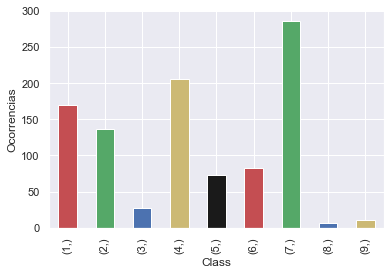

Observações na classe 7 : 286 ( 28.686 %)
Observações na classe 4 : 206 ( 20.662 %)
Observações na classe 1 : 170 ( 17.051 %)
Observações na classe 2 : 136 ( 13.641 %)
Observações na classe 6 : 82 ( 8.225 %)
Observações na classe 5 : 73 ( 7.322 %)
Observações na classe 3 : 27 ( 2.708 %)
Observações na classe 9 : 11 ( 1.103 %)
Observações na classe 8 : 6 ( 0.602 %)


In [58]:
distribuicao(pd.DataFrame(y_test), verbose = True)

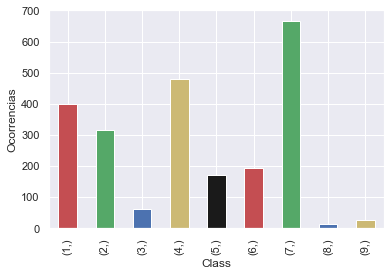

Observações na classe 7 : 667 ( 28.701 %)
Observações na classe 4 : 480 ( 20.654 %)
Observações na classe 1 : 398 ( 17.126 %)
Observações na classe 2 : 316 ( 13.597 %)
Observações na classe 6 : 193 ( 8.305 %)
Observações na classe 5 : 169 ( 7.272 %)
Observações na classe 3 : 62 ( 2.668 %)
Observações na classe 9 : 26 ( 1.119 %)
Observações na classe 8 : 13 ( 0.559 %)


In [59]:
distribuicao(pd.DataFrame(y_train), verbose = True)

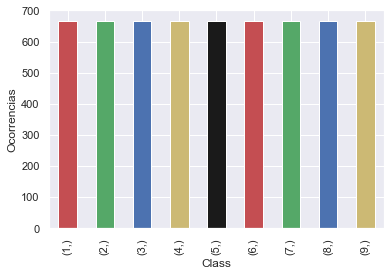

Observações na classe 1 : 667 ( 11.111 %)
Observações na classe 2 : 667 ( 11.111 %)
Observações na classe 3 : 667 ( 11.111 %)
Observações na classe 4 : 667 ( 11.111 %)
Observações na classe 5 : 667 ( 11.111 %)
Observações na classe 6 : 667 ( 11.111 %)
Observações na classe 7 : 667 ( 11.111 %)
Observações na classe 8 : 667 ( 11.111 %)
Observações na classe 9 : 667 ( 11.111 %)


In [60]:
distribuicao(pd.DataFrame(y_train_resample), verbose = True)

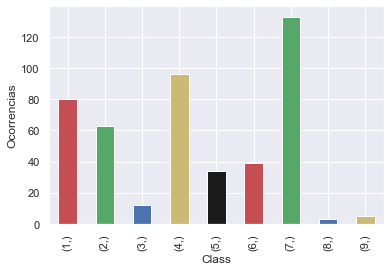

Observações na classe 7 : 133 ( 28.602 %)
Observações na classe 4 : 96 ( 20.645 %)
Observações na classe 1 : 80 ( 17.204 %)
Observações na classe 2 : 63 ( 13.548 %)
Observações na classe 6 : 39 ( 8.387 %)
Observações na classe 5 : 34 ( 7.312 %)
Observações na classe 3 : 12 ( 2.581 %)
Observações na classe 9 : 5 ( 1.075 %)
Observações na classe 8 : 3 ( 0.645 %)


In [61]:
distribuicao(pd.DataFrame(y_validacao), verbose = True)

# 7. Modelagem Preditiva

## 7.1 Criação de Modelos Bases

Primeiramente iremos criar os modelos bases para entender qual comportamento é melhor para os nossos modelos preditivos. Os modelos bases irão ser criados com as seguintes configurações:

    - Balanceamento em treino = True or False
    - Calibracao = True or False
    - Conjunto de calibracao: Treino ou validacao
   
Para as configuracoes acima, iremos utilizar os seguintes algoritmos: Regressão Logistica, Linear SVM, Random Forest, XGBoost e KNN.

In [91]:
configuracoes = []

In [106]:
def executaModelo(modelo, treino, teste, validacao, calibration = False):
    try:
        # Treina o modelo
        modelo.fit(treino[0], treino[1])

        if calibration:
            # Instancia a calibração
            calibration = CalibratedClassifierCV(base_estimator = modelo, method = 'sigmoid', cv = 3)
            
            # Aplica a calibração
            calibration.fit(validacao[0], validacao[1])

            # Realiza as previsões
            pred = calibration.predict_proba(teste[0])
        else:
            # Realiza as previsões de acordo com o tipo do modelo probabilistico ou não
            try:           
                pred = modelo.predict_proba(teste[0])
            except:
                pred = modelo.predict(teste[0])

        # Calcula a loss
        loss = log_loss(teste[1], pred)
        
        return loss    
    except:
        print('Treino ignorado')
    
    return -1

In [93]:
def executaModelos(modelo, data_treino_balanceado, data_treino_desbalanceado, data_validacao,\
                  data_treino_validacao_balanceado, data_treino_validacao_desbalanceado, data_teste, algoritmo):
    global configuracoes
    
    # Balanceamento em treino, calibracao, conjunto de calibracao em treino
    print('Iniciando treino 1...')
    
    loss = executaModelo(modelo, data_treino_balanceado, data_teste, data_treino_balanceado, True)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': True,\
                              'Calibracao': True, 'Conjunto Calibracao': 'Treino', 'Loss': loss})
    
    # Balanceamento em treino, calibracao, conjunto de calibracao em validacao
    print('Iniciando treino 2...')
    
    loss = executaModelo(modelo, data_treino_validacao_balanceado, data_teste, data_validacao, True)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': True,\
                            'Calibracao': True, 'Conjunto Calibracao': 'Validacao', 'Loss': loss})
    
    # Balanceamento em treino, sem calibracao
    print('Iniciando treino 3...')
    
    loss = executaModelo(modelo, data_treino_balanceado, data_teste, [], False)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': True,\
                              'Calibracao': False, 'Conjunto Calibracao': None, 'Loss': loss})
    
    # Desbalanceamento em treino, calibracao, conjunto de calibracao em treino
    print('Iniciando treino 4...')
    
    loss = executaModelo(modelo, data_treino_desbalanceado, data_teste, data_treino_desbalanceado, True)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': False,\
                            'Calibracao': True, 'Conjunto Calibracao': 'Treino', 'Loss': loss})
    
    # Desbalanceamento em treino, calibracao, conjunto de calibracao em validacao
    print('Iniciando treino 5...')
    
    loss = executaModelo(modelo, data_treino_validacao_desbalanceado, data_teste, data_validacao, True)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': False,\
                              'Calibracao': True, 'Conjunto Calibracao': 'Validacao', 'Loss': loss})
    
    # Desbalanceamento em treino, sem calibracao
    print('Iniciando treino 6...')
    
    loss = executaModelo(modelo, data_treino_desbalanceado, data_teste, [], False)
    
    if loss != -1:
        configuracoes.append({'Algoritmo': algoritmo, 'Balanceamento': False,\
                              'Calibracao': False, 'Conjunto Calibracao': None, 'Loss': loss})
        

In [94]:
# Executando todas as configurações citadas para o algoritmo de Regressão Logistica
executaModelos(SGDClassifier(loss = 'log', class_weight = 'balanced', random_state = seed_),\
             [X_train_resample, y_train_resample], [X_train, y_train], [X_validacao, y_validacao],\
             [X_train_resample_, y_train_resample_], [X_train_, y_train_], [X_test, y_test], 'Regressão Logistica')

Iniciando treino 1...
Iniciando treino 2...
Iniciando treino 3...
Iniciando treino 4...
Iniciando treino 5...
Iniciando treino 6...
Treino ignorado


In [95]:
# Executando todas as configurações citadas para o algoritmo de Linear SVM
executaModelos(SGDClassifier(loss = 'hinge', class_weight = 'balanced', random_state = seed_),\
             [X_train_resample, y_train_resample], [X_train, y_train], [X_validacao, y_validacao],\
             [X_train_resample_, y_train_resample_], [X_train_, y_train_], [X_test, y_test], ' Linear SVM')

Iniciando treino 1...
Iniciando treino 2...
Iniciando treino 3...
Treino ignorado
Iniciando treino 4...
Iniciando treino 5...
Iniciando treino 6...
Treino ignorado


In [96]:
# Executando todas as configurações citadas para o algoritmo de KNN
executaModelos(KNeighborsClassifier(),\
             [X_train_resample, y_train_resample], [X_train, y_train], [X_validacao, y_validacao],\
             [X_train_resample_, y_train_resample_], [X_train_, y_train_], [X_test, y_test], 'KNN')

Iniciando treino 1...
Iniciando treino 2...
Iniciando treino 3...
Iniciando treino 4...
Iniciando treino 5...
Iniciando treino 6...


In [97]:
# Executando todas as configurações citadas para o algoritmo de Random Forest
executaModelos(RandomForestClassifier(random_state = seed_),\
             [X_train_resample, y_train_resample], [X_train, y_train], [X_validacao, y_validacao],\
             [X_train_resample_, y_train_resample_], [X_train_, y_train_], [X_test, y_test], 'Random Forest')

Iniciando treino 1...
Iniciando treino 2...
Iniciando treino 3...
Iniciando treino 4...
Iniciando treino 5...
Iniciando treino 6...


In [103]:
# Ordena os modelos de acordo com a menor Loss
sorted_configuracoes = sorted(configuracoes, key = lambda k: k['Loss'])

Abaixo visualizamos que os 2 melhores modelos são do mesmo algoritmo, Random Forest. A unica diferença entre eles é em relação ao balanceamento um possuo e o outro não. 

Configuração do melhor modelo:
  - 'Algoritmo': 'Random Forest',
  - 'Balanceamento': False,
  - 'Calibracao': True,
  - 'Conjunto Calibracao': 'Treino',
  - 'Loss': 1.21

In [105]:
sorted_configuracoes[0:3]

[{'Algoritmo': 'Random Forest',
  'Balanceamento': False,
  'Calibracao': True,
  'Conjunto Calibracao': 'Treino',
  'Loss': 1.210792880971744},
 {'Algoritmo': 'Random Forest',
  'Balanceamento': True,
  'Calibracao': True,
  'Conjunto Calibracao': 'Treino',
  'Loss': 1.2355703964087525},
 {'Algoritmo': 'KNN',
  'Balanceamento': False,
  'Calibracao': True,
  'Conjunto Calibracao': 'Treino',
  'Loss': 1.391483412602848}]

In [76]:
def plot_confusion_matrix(test_y, predict_y):
    
    # Calculating Confusion Matrix
    cm = confusion_matrix(test_y, predict_y)
    
    # Calculating Precision Matrix
    precision = (cm/cm.sum(axis=0))
    
    # Calculating Recall Matrix
    recall = (((cm.T)/(cm.sum(axis=1))).T)
    
    labels = range(1, 10)
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(cm, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(precision, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(recall, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Classe Prevista')
    plt.ylabel('Classe Real')
    plt.show()

In [64]:
# Modelo
modelo = RandomForestClassifier(random_state = seed_)
modelo.fit(X_train, y_train)

# Calibração
calibration = CalibratedClassifierCV(base_estimator = modelo, method = 'sigmoid', cv = 3)
calibration.fit(X_train, y_train)

# Realiza as previsões
pred = calibration.predict(X_test)
pred_prob = calibration.predict_proba(X_test)

# Calcula a loss
loss = log_loss(y_test, pred_prob)

print('Loss:', round(loss, 4))

Loss: 1.2108


<ipython-input-76-d3ffbe4913cb>:7: RuntimeWarning: invalid value encountered in true_divide
  precision = (cm/cm.sum(axis=0))


-------------------- Confusion matrix --------------------


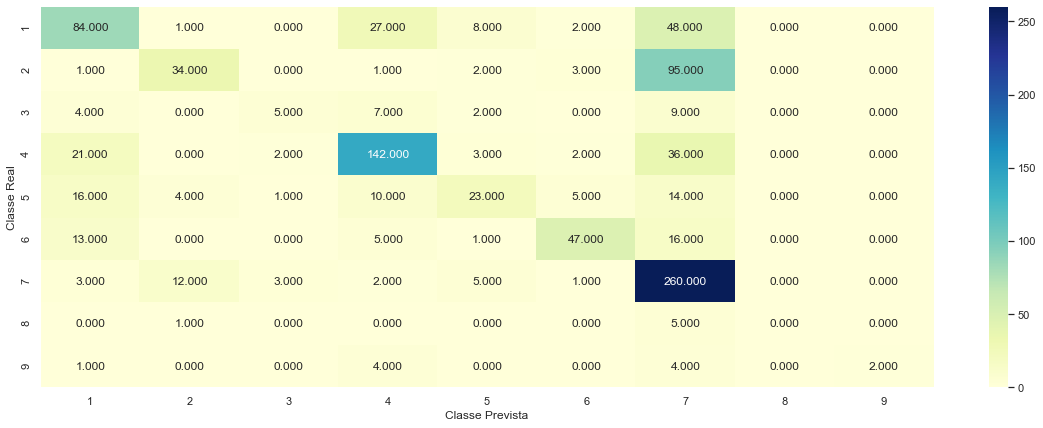

-------------------- Precision matrix --------------------


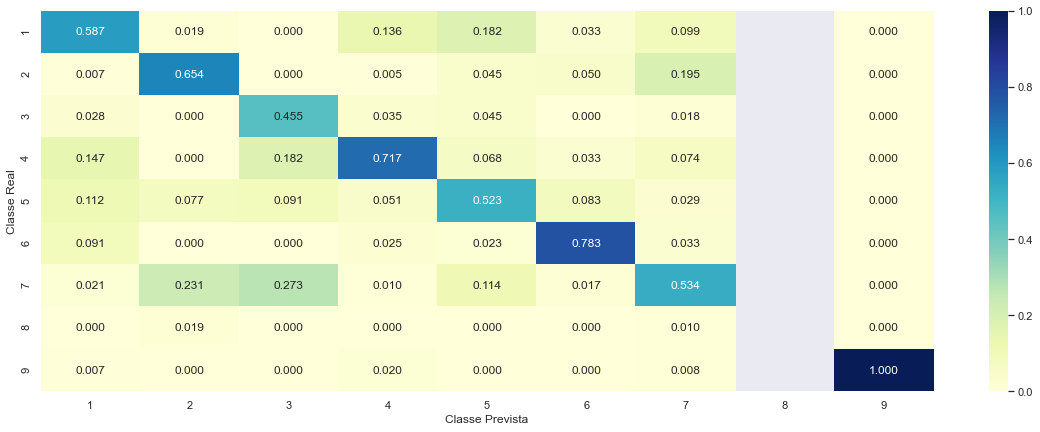

-------------------- Recall matrix --------------------


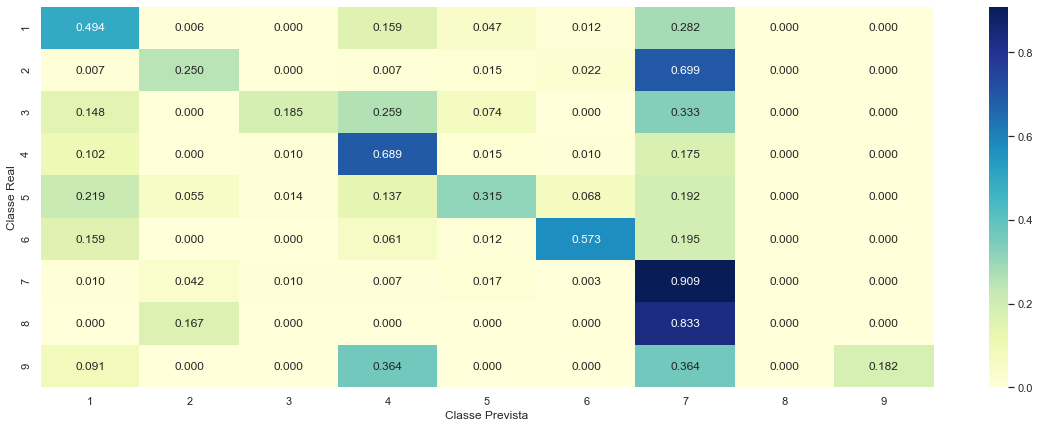

In [77]:
plot_confusion_matrix(y_test, pred)

## 7.2 Tuning Random Forest

Com a escolha do melhor algoritmo como sendo Random Forest, iremos realizar o seu Tuning. Tentar encontrar os melhores hiperparametros.